LSTM method using this method as a source https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

tldr: Transform dataset into supervised method, make it stationary, transform to scale, LSTM

In [79]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

Creating a single model and retraining over same-scale time series

NN specific and "To be used in the future"

In [81]:
# meee
def create_lstm(train, batch_size, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

# fits me
def fit_model(model, nb_epoch):
    pass

Alternative prediction using the last predicted value as the input. This is necessary because we want to predict more than one time unit ahead.

Lets try with another dataset

In [82]:
def scale2(train_data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_data)
    # transform train
    train = train_data.reshape(train_data.shape[0], train_data.shape[1])
    train_scaled = scaler.transform(train_data)
    return scaler, train_scaled

def make_predictions(lstm_model, train_scaled, scaler, raw_values, number_of_predictions):
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    scaled_predictions = list()
    predictions = list()
    X = train_scaled[-1,1:2]

    yhat = forecast_lstm(lstm_model, 1, X)
    scaled_predictions.append(yhat)
    
    yhat = invert_scale(scaler, X, yhat)
    yhat = yhat + raw_values[-1]
    predictions.append(yhat)
    
    # Predict N steps into the FUTURE!
    for i in range(1, number_of_predictions):
        X = np.array([scaled_predictions[-1]])
        yhat = forecast_lstm(lstm_model, 1, X)
        scaled_predictions.append(yhat)
        
        yhat = invert_scale(scaler, X, yhat)
        yhat = yhat + predictions[-1]
        predictions.append(yhat)
    
    # removed for mass predictions
    #print(scaled_predictions)
    #print(predictions)

    return predictions
    

def create_model_and_predict(train_series, number_of_predictions):
    # transform data to be stationary
    raw_values = train_series.values
    diff_values = difference(raw_values, 1)

    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    # transform the scale of the data
    scaler, train_scaled = scale2(supervised_values)

    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 10, 4)
    
    predictions = make_predictions(lstm_model, train_scaled, scaler, raw_values, number_of_predictions)
    return predictions

Failsafe single prediction

In [83]:
# Prediction lengths for different scopes
horizon_lengths = {"H" : 48, "D" : 14, "M" : 18, "Q" : 8, "Y" : 6}

# Load datasets
train_set = pd.read_csv('./data/cut/1000/train/Daily.csv')
test_set = pd.read_csv('./data/cut/1000/test/Daily.csv')

# load dataset
series_name = train_set.iloc[1,1]
n_predictons = horizon_lengths[series_name[0].upper()]

series = train_set.iloc[1,2:].dropna()
test_series = test_set.iloc[1,1:]

# Predict from the series
pred = create_model_and_predict(series, n_predictons)

Loopy predictions

In [84]:
import os

# Prediction lengths for different scopes
horizon_lengths = {"H" : 48, "D" : 14, "M" : 18, "Q" : 8, "Y" : 6}

# All filenames for different scopes
filenames = os.listdir("./data/cut/1000/train/")

# Results
results_frame = pd.DataFrame()

# Test series frame for plotting or w/e
test_frame = pd.DataFrame()

for file in filenames:
    print("Started training using " + file + "...")
    
    # Load datasets
    train_set = pd.read_csv('./data/cut/1000/train/' + file)
    test_set = pd.read_csv('./data/cut/1000/test/' + file)
    
    # Go through all the time series in the scope 
    for i in range(1, train_set.shape[0]):
        # load dataset
        series_name = train_set.iloc[i,1]
        n_predictons = horizon_lengths[series_name[0].upper()]
        
        series = train_set.iloc[i,2:].dropna()
        test_series = test_set.iloc[i,1:].tolist()
        test_series.insert(0, series_name)
        
        # Predict from the series
        pred = create_model_and_predict(series, n_predictons)
        pred.insert(0, series_name)
        
        # Square brackets append the list as a row
        results_frame = results_frame.append([pred], ignore_index=True)
        test_frame = test_frame.append([test_series], ignore_index=True)

        print("Time series " + series_name + " predictions completed")        
        #assert False
    
    print(file + " training completed.")

Started training using Daily.csv...
Time series D357 predictions completed


AssertionError: 

Write the resulting data frame to .csv

In [85]:
results_frame.to_csv("./results.csv", index=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,D357,7146.88,7168.75,7162.5,7165.62,7209.38,7165.62,7159.38,7081.25,7009.38,6937.5,6925.0,6959.38,6912.5,6871.88


Printing out a single prediction, if one so chooses

Test RMSE: 191.499


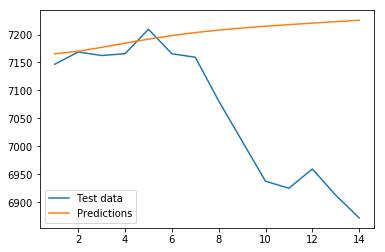

In [86]:
rmse = np.sqrt(mean_squared_error(test_frame.iloc[0, 1:], results_frame.iloc[0, 1:]))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test_frame.iloc[0, 1:], label="Test data")
plt.plot(results_frame.iloc[0, 1:], label="Predictions")
plt.legend()
plt.show()

In [ ]:
len(pred)